In [2]:
import numpy as np
import numpy.ma as ma
import scipy.stats
import netCDF4

import matplotlib.patches
import matplotlib.gridspec
import datetime

from matplotlib.patches import Ellipse, Polygon #https://stackoverflow.com/questions/38168948/how-to-decouple-hatch-and-edge-color-in-matplotlib/38169221

import matplotlib.pyplot as plt
%matplotlib inline

degree_sign = '\N{DEGREE SIGN}'

import cartopy.crs as ccrs

from scipy.io import savemat  #####To save as .mat

import numpy.matlib

import scipy.linalg as la

import scipy.sparse.linalg as sparse

import pickle #######For saving dictionaries https://stackoverflow.com/questions/11218477/how-can-i-use-pickle-to-save-a-dict
import bottleneck as bn #### For running mean https://stackoverflow.com/questions/13728392/moving-average-or-running-mean

import time as time_seconds

### Cristian Martinez-Villalobos, April 20, 2023

#### Clase 6 "Ciencia de Datos para Análisis de Cambio Climático"

In [2]:
###### This calculates the monthly mean in each lat/lon grid point

def monthly_mean(timeserie,lat,lon): ####Needs to be of leangth multiple of 365
    monthly_mean=np.zeros((12,len(lat),len(lon)))
    t0=time_seconds.perf_counter()
    for j in range(0,len(lon)):
        for i in range(0,len(lat)):
            for k in range(0,12):
                monthly_mean[k,i,j]=np.mean(timeserie[k:-1:12,i,j])
        t1=time_seconds.perf_counter()
        if j%20==0:
            print(100*(j+1)/len(lon),'% ',t1-t0,'s')  ####To check how long it takes
        
    return monthly_mean

In [3]:
####Define function to remove seasonal cycle
def seas_cycle_fit(seas_cycle): #### array (12,) with the mean each day
    y=np.zeros([1,len(seas_cycle)]) #1xlength(bin)
    x=np.zeros([5,len(seas_cycle)])  ##Predictors 3xbin
    t=np.arange(1,12.1)

    y[0,:]=seas_cycle
    x[0,:]=np.ones(seas_cycle.shape)
    x[1,:]=np.cos(2*np.pi*t/12)
    x[2,:]=np.sin(2*np.pi*t/12)
    x[3,:]=np.cos(4*np.pi*t/12)
    x[4,:]=np.sin(4*np.pi*t/12)

    coeff=y.dot(np.linalg.pinv(x))
    seas_cycle_fit=np.squeeze(np.matmul(coeff,x))
     
    return seas_cycle_fit ###Returns (array (365,)) with seasonal cycle fitted with two harmonics.

#### Patrones Espaciales Asociados a Modos de Variabilidad Climáticos

##### En estos ejemplos graficaremos los patrones de temperatura superficial del mar y vientos asociados con el fenómeno de El Niño

In [4]:
#### Pasos:
#### 1. Calcularemos un índice asociado a El Niño (ver clase pasada)
#### 2. Calcularemos el patrón espacial asociado a este índice usando "Composite Analysis"
#### 3. Calcularemos el patrón espacial asociado a este índice usando Regresión Lineal
#### 4. Compararemos las similitudes y diferencias de usar estos dos métodos

#### 1. Calculamos el índice Niño 3.4 (ver clase pasada)

### Cargamos la temperatura superficial del mar y vientos zonales y meridionales

In [3]:
### In case we want seasonal data

#season='DJF'; months=[12,1,2]
#season='MAM'; months=[3,4,5]
#season='JJA'; months=[6,7,8]
#season='SON'; months=[9,10,11]
season='annual'; months=[1,2,3,4,5,6,7,8,9,10,11,12]

#### Initial, final year of analysis

In [4]:
year_init=1948
year_fin=2020

#### Load SST from 1948 to 2020

In [7]:
####Here we load the whole file
t0=time_seconds.perf_counter()

hist_start=datetime.datetime(year_init,1,1)  ####SSH only covers these years. Precip starts in 1979
hist_end=datetime.datetime(year_fin,12,31)

file_root='/Users/cristianmartinez/iCloud/Tramites/Adolfo_Ibañez/Docencia/Mis_cursos/2023_01_Ciencia_Datos_Cambio_Climatico/2023_03_08_Clases/Data/' #### Replace with folder where file is located
filename='sst.mnmean_2.5x2.5.nc' #### replace with name of the file

ncfile = netCDF4.Dataset(file_root + filename, 'r', format='NETCDF4')
time = ncfile.variables['time']
time_converted = netCDF4.num2date(time[:], time.units)#, time.calendar) ###year, month, day
time_indices = np.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_converted])

lat = ncfile.variables['lat'][:]
lon = ncfile.variables['lon'][:]

# ######## have lon go between 0 and 360

sst = ncfile.variables['sst'][time_indices,:,:]

t1=time_seconds.perf_counter()

print(t1-t0,'s')  #####This is to check how long it takes

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/cristianmartinez/iCloud/Tramites/Adolfo_Iba\xc3\xb1ez/Docencia/Mis_cursos/2023_01_Ciencia_Datos_Cambio_Climatico/2023_03_08_Clases/Data/sst.mnmean_2.5x2.5.nc'

#### Load zonal wind from 1948 to 2020 (viento zonal= de oeste a este)

In [8]:
####Here we load the whole file
t0=time_seconds.perf_counter()

file_root='/Users/maxter/Downloads/CDDAmbientales/Clase6_CDDCC/' #### Replace with folder where file is located
filename='uwnd.mon.mean_2.5x2.5.nc' #### replace with name of the file

ncfile = netCDF4.Dataset(file_root + filename, 'r', format='NETCDF4')
time = ncfile.variables['time']
time_converted = netCDF4.num2date(time[:], time.units)#, time.calendar) ###year, month, day
time_indices = np.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_converted])

lat = ncfile.variables['lat'][:]
lon = ncfile.variables['lon'][:]

# ######## have lon go between 0 and 360

uas = ncfile.variables['uas'][time_indices,:,:]

t1=time_seconds.perf_counter()

print(t1-t0,'s')  #####This is to check how long it takes

0.18487241700000112 s


In [9]:
uas.shape

(876, 72, 144)

#### Load meridional wind from 1948 to 2020 (viento meridional = de sur a norte)

In [9]:
####Here we load the whole file
t0=time_seconds.perf_counter()

file_root='/Users/cristianmartinez/iCloud/Tramites/Adolfo_Ibañez/Docencia/Mis_cursos/2023_01_Ciencia_Datos_Cambio_Climatico/2023_03_08_Clases/Data/' #### Replace with folder where file is located
filename='vwnd.mon.mean_2.5x2.5.nc' #### replace with name of the file

ncfile = netCDF4.Dataset(file_root + filename, 'r', format='NETCDF4')
time = ncfile.variables['time']
time_converted = netCDF4.num2date(time[:], time.units)#, time.calendar) ###year, month, day
time_indices = np.array([(t.month in months)&(t.year in range(hist_start.year, hist_end.year+1)) for t in time_converted])

lat = ncfile.variables['lat'][:]
lon = ncfile.variables['lon'][:]

# ######## have lon go between 0 and 360

vas = ncfile.variables['vas'][time_indices,:,:]

t1=time_seconds.perf_counter()

print(t1-t0,'s')  #####This is to check how long it takes

0.09329769000009946 s


In [11]:
sst.shape

(876, 72, 144)

##### Calculate anomalies with respect to seasonal cycle 

In [12]:
#### This function calculates seasonal cycle
mean_monthly_sst=monthly_mean(sst,lat,lon)
mean_monthly_uas=monthly_mean(uas,lat,lon)
mean_monthly_vas=monthly_mean(vas,lat,lon)

<ipython-input-2-859d448986da>:9: UserWarning: Warning: converting a masked element to nan.
  monthly_mean[k,i,j]=np.mean(timeserie[k:-1:12,i,j])


0.6944444444444444 %  0.06308358699993732 s
14.583333333333334 %  0.7337252269999226 s
28.47222222222222 %  1.3983510620000743 s
42.361111111111114 %  2.0684886690000894 s
56.25 %  2.8151789999999437 s
70.13888888888889 %  3.508131675999948 s
84.02777777777777 %  4.243034048000027 s
97.91666666666667 %  4.924097563000032 s
0.6944444444444444 %  0.0771246679998967 s
14.583333333333334 %  1.4941162769998755 s
28.47222222222222 %  2.8413656529999116 s
42.361111111111114 %  4.198793318999833 s
56.25 %  5.642289734999849 s
70.13888888888889 %  7.082326888999887 s
84.02777777777777 %  8.510686312999951 s
97.91666666666667 %  9.870399589999806 s
0.6944444444444444 %  0.07463503700000729 s
14.583333333333334 %  1.4150156610000977 s
28.47222222222222 %  2.785479905000102 s
42.361111111111114 %  4.165217467000048 s
56.25 %  5.544016920000104 s
70.13888888888889 %  6.994574317000115 s
84.02777777777777 %  8.316954754000108 s
97.91666666666667 %  9.674146487000144 s


In [13]:
##3## Hacemos un fit al ciclo estacional removiendo los dos primeros harmònicos de Fourier
mean_monthly_sst_fit_tem=np.zeros(mean_monthly_sst.shape)
mean_monthly_uas_fit_tem=np.zeros(mean_monthly_uas.shape)
mean_monthly_vas_fit_tem=np.zeros(mean_monthly_vas.shape)

t0=time_seconds.perf_counter()
for j in range(0,len(lon)): 
    for i in range(0,len(lat)):
        mean_monthly_sst_fit_tem[:,i,j]=seas_cycle_fit(mean_monthly_sst[:,i,j])
        mean_monthly_uas_fit_tem[:,i,j]=seas_cycle_fit(mean_monthly_uas[:,i,j])
        mean_monthly_vas_fit_tem[:,i,j]=seas_cycle_fit(mean_monthly_vas[:,i,j])
    t1=time_seconds.perf_counter()
    if j%20==0:
        print(100*(j+1)/len(lon),'% ',t1-t0,'s')

0.6944444444444444 %  0.049002331999872695 s
14.583333333333334 %  0.4006301770000391 s
28.47222222222222 %  0.7358579429999281 s
42.361111111111114 %  1.063789627999995 s
56.25 %  1.3860189969998373 s
70.13888888888889 %  1.7284652819998882 s
84.02777777777777 %  2.0868603229998826 s
97.91666666666667 %  2.420418042999927 s


#### Hacemos copias de N_years=73 (1948-2020) años

In [14]:
#### Make N_years copies (N_years= repleace with number of years of the dataset. For monthly data this is len(timeseries[:,0,0])/12)
N_years=int(year_fin-year_init+1)
mean_monthly_sst_fit=np.zeros(sst.shape)
mean_monthly_uas_fit=np.zeros(uas.shape)
mean_monthly_vas_fit=np.zeros(vas.shape)

for i in range(0,N_years):
    mean_monthly_sst_fit[12*i:12*(i+1),:,:]=mean_monthly_sst_fit_tem
    mean_monthly_uas_fit[12*i:12*(i+1),:,:]=mean_monthly_uas_fit_tem
    mean_monthly_vas_fit[12*i:12*(i+1),:,:]=mean_monthly_vas_fit_tem

#### Plot to check whether seasonal cycle is well calculated

Text(0.5, 1.0, 'Ciclo estacional meridional wind')

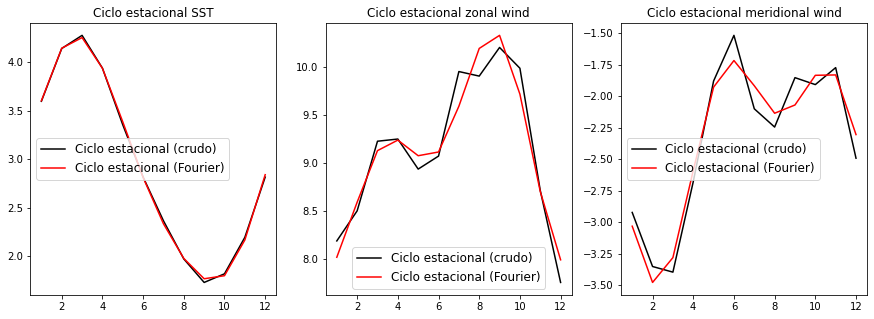

In [17]:
### chequeamos en un punto cualquiera

i=15
j=20

fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1,3,1)
ax.plot(np.arange(1,12.1),mean_monthly_sst[:,i,j],'-k',label='Ciclo estacional (crudo)')
ax.plot(np.arange(1,12.1),mean_monthly_sst_fit_tem[:,i,j],'-r',label='Ciclo estacional (Fourier)')
ax.legend(loc='best',fontsize=12)
ax.set_title('Ciclo estacional SST')

ax = fig.add_subplot(1,3,2)
ax.plot(np.arange(1,12.1),mean_monthly_uas[:,i,j],'-k',label='Ciclo estacional (crudo)')
ax.plot(np.arange(1,12.1),mean_monthly_uas_fit_tem[:,i,j],'-r',label='Ciclo estacional (Fourier)')
ax.legend(loc='best',fontsize=12)
ax.set_title('Ciclo estacional zonal wind')

ax = fig.add_subplot(1,3,3)
ax.plot(np.arange(1,12.1),mean_monthly_vas[:,i,j],'-k',label='Ciclo estacional (crudo)')
ax.plot(np.arange(1,12.1),mean_monthly_vas_fit_tem[:,i,j],'-r',label='Ciclo estacional (Fourier)')
ax.legend(loc='best',fontsize=12)
ax.set_title('Ciclo estacional meridional wind')

#### Calculamos anomalìas emoviendo el ciclo estacional

In [18]:
#### SSTA, UA, and VA are sea surface temperature, zonal wind, and meridional wind anomalies at each point of the grid respect to their respective seasonal cyles

SSTA=sst-mean_monthly_sst_fit
UA=uas-mean_monthly_uas_fit
VA=vas-mean_monthly_vas_fit

#### Calculamos el índice Niño 3.4

In [19]:
lat_lo=-5; lat_hi = 5; lon_lo = 190; lon_hi = 240; ####Niño 3.4 region https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

model_lon_indices = (lon>=lon_lo) & (lon<=lon_hi)
model_lat_indices = (lat>=lat_lo) & (lat<=lat_hi)

##### Apply indices

SSTA_ni=SSTA[:,model_lat_indices,:][:,:,model_lon_indices]

Nino34=np.mean(np.mean(SSTA_ni,axis=2),axis=1)

np.std(Nino34)

0.8658508975487197

Text(0.5, 1.0, '$\\mathbf{a.}$ Niño 3.4 index')

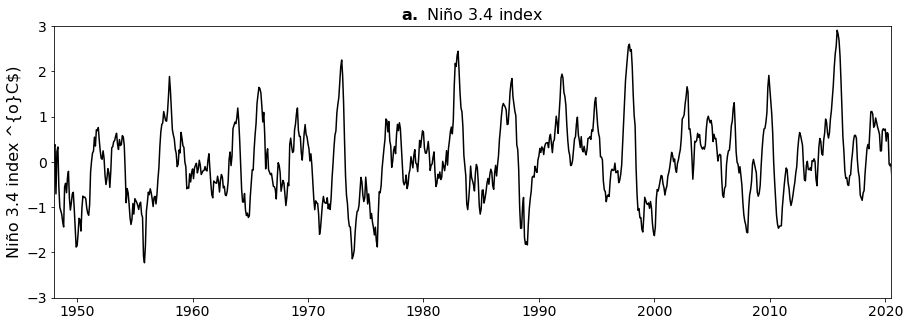

In [61]:
fontsize=16

fig = plt.figure(figsize=(15,5))  ###figsize width height in inches https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.figure.html

#########
ax4 = fig.add_subplot(1,1,1)
# ax4.plot(np.arange(1,12.1),monthly_acc_pr3m, 'ko-',linewidth=1.5)
ax4.plot(np.arange(year_init,year_fin+1,1/12),Nino34, 'k-',linewidth=1.5) 
# ax4.legend(loc='best',fontsize=14)
# ax4.set_xlabel('', fontsize=fontsize)
ax4.tick_params(labelsize=fontsize-2)
ax4.set_ylabel(r'Niño 3.4 index ^{o}C$)', fontsize=fontsize)
ax4.set_ylim(-3,3)
ax4.set_xlim(year_init,year_fin+1/2)
ax4.set_title(r'$\mathbf{a.}$ Niño 3.4 index' , fontsize=16)

#### 2. Calculamos patrón espacial (Composite Analysis)

##### Usaremos el criterio que una anomalía del índice Niño 3.4 >0.5C corresponde a El Niño, <-0.5C corresponde a La Niña, y el resto es un estado neutral

#### El Niño composite, La Niña composite and Neutral composite

In [29]:
I_nino=np.argwhere(Nino34>=0.5)
I_nina=np.argwhere(Nino34<=-0.5)
I_neutral=np.argwhere((Nino34>-0.5) & (Nino34<0.5))

SSTA_nino=np.squeeze(SSTA[I_nino,:,:]) #### Seleccionamos sólo los meses con Niño3.4>0.5 (note: np.squeeze removes singleton dimension)
UA_nino=np.squeeze(UA[I_nino,:,:]) #### Seleccionamos sólo los meses con Niño3.4>0.5 (note: np.squeeze removes singleton dimension)
VA_nino=np.squeeze(VA[I_nino,:,:]) #### Seleccionamos sólo los meses con Niño3.4>0.5 (note: np.squeeze removes singleton dimension)

SSTA_nina=np.squeeze(SSTA[I_nina,:,:]) #### Seleccionamos sólo los meses con Niño3.4>-0.5 (note: np.squeeze removes singleton dimension)
UA_nina=np.squeeze(UA[I_nina,:,:]) #### Seleccionamos sólo los meses con Niño3.4>-0.5 (note: np.squeeze removes singleton dimension)
VA_nina=np.squeeze(VA[I_nina,:,:]) #### Seleccionamos sólo los meses con Niño3.4>-0.5 (note: np.squeeze removes singleton dimension)

SSTA_neutral=np.squeeze(SSTA[I_neutral,:,:]) #### Seleccionamos sólo los meses con Niño3.4<0.5 y Nino34>-0.5 (note: np.squeeze removes singleton dimension)
UA_neutral=np.squeeze(UA[I_neutral,:,:]) #### Seleccionamos sólo los meses con Niño3.4<0.5 y Nino34>-0.5 (note: np.squeeze removes singleton dimension)
VA_neutral=np.squeeze(VA[I_neutral,:,:]) #### Seleccionamos sólo los meses con Niño3.4<0.5 y Nino34>-0.5 (note: np.squeeze removes singleton dimension)


#### El "composite" es el promedio de todos

In [34]:
SSTA_nino_composite=np.mean(SSTA_nino,axis=0)
SSTA_nina_composite=np.mean(SSTA_nina,axis=0)
SSTA_neutral_composite=np.mean(SSTA_neutral,axis=0)

UA_nino_composite=np.mean(UA_nino,axis=0)
UA_nina_composite=np.mean(UA_nina,axis=0)
UA_neutral_composite=np.mean(UA_neutral,axis=0)

VA_nino_composite=np.mean(VA_nino,axis=0)
VA_nina_composite=np.mean(VA_nina,axis=0)
VA_neutral_composite=np.mean(VA_neutral,axis=0)

#### Plot composite 

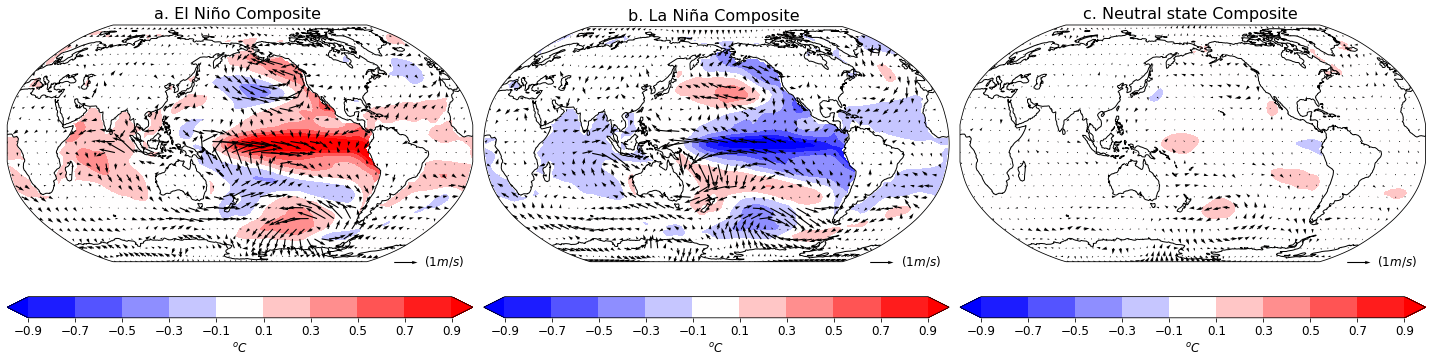

In [54]:
######Start with Nino4,Nino3,Nino1+2

fontsize=12

#### To plot data
LON,LAT = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SSTA_nino_composite, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], UA_nino_composite[0::3,0::3],VA_nino_composite[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'a. El Niño Composite ', fontsize=16)

####### La Niña

ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SSTA_nina_composite, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], UA_nina_composite[0::3,0::3],VA_nina_composite[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'b. La Niña Composite ', fontsize=16)

####### Neutral state composite

ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SSTA_neutral_composite, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], UA_neutral_composite[0::3,0::3],VA_neutral_composite[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'c. Neutral state Composite ', fontsize=16)

fig.tight_layout()

#### 3. Calculamos patrón espacial (Regression Analysis)

##### Aquí asumimos que una anomalía de una variable climática x en un punto determinado puede ser explicada linealmente por un índice (en nuestro caso Niño3.4)

#### i.e., $SSTA[t,x,y]=\alpha (x,y) Nino(t)$, $UA[t,x,y]=\beta (x,y) Nino(t)$, $VA[t,x,y]=\gamma (x,y) Nino(t)$

#### Los patrones están encapsulados en $\alpha$, $\beta$ y $\gamma$, con unidades $[\alpha]=()$, $[\beta]=[\gamma]=\frac{m/s}{^{o}C}$

#### En cada punto de la grilla y para cada variable calculamos una regresión lineal en nuestro índice

In [51]:
#### Calculate regression coefficients

N_months=12*N_years

reg_SST=np.zeros((len(lat),len(lon)))
reg_U=np.zeros((len(lat),len(lon)))
reg_V=np.zeros((len(lat),len(lon)))
   
for j in range(0,len(lon)):
    for i in range(0,len(lat)):
        y=np.zeros([1,N_months]) #1xlength(bin)
        x=np.zeros([1,N_months])  ##Predictors 3xbin

        y[0,:]=SSTA[:,i,j]
        x[0,:]=Nino34

        coeff=y.dot(np.linalg.pinv(x))

        y_rec=coeff[0][0]*x
        
        reg_SST[i,j]=coeff[0][0]
        
        ############
        y=np.zeros([1,N_months]) #1xlength(bin)
        x=np.zeros([1,N_months])  ##Predictors 3xbin

        y[0,:]=UA[:,i,j]
        x[0,:]=Nino34

        coeff=y.dot(np.linalg.pinv(x))

        y_rec=coeff[0][0]*x
        
        reg_U[i,j]=coeff[0][0]
        
        ############
        y=np.zeros([1,N_months]) #1xlength(bin)
        x=np.zeros([1,N_months])  ##Predictors 3xbin

        y[0,:]=VA[:,i,j]
        x[0,:]=Nino34

        coeff=y.dot(np.linalg.pinv(x))

        y_rec=coeff[0][0]*x
        
        reg_V[i,j]=coeff[0][0]


    t1=time_seconds.perf_counter()
    if j%10==0:
        print(100*(j+1)/len(lon),'% ',t1-t0,'s')
        
reg_SST[np.absolute(reg_SST)>10000]=0

0.6944444444444444 %  4481.2389735589995 s
7.638888888888889 %  4481.510230947 s
14.583333333333334 %  4481.770239368 s
21.52777777777778 %  4482.024353142 s
28.47222222222222 %  4482.276993882 s
35.416666666666664 %  4482.512048176 s
42.361111111111114 %  4482.737754533 s
49.30555555555556 %  4482.97377162 s
56.25 %  4483.20021892 s
63.19444444444444 %  4483.427488331 s
70.13888888888889 %  4483.659695742 s
77.08333333333333 %  4483.878475148 s
84.02777777777777 %  4484.105981239 s
90.97222222222223 %  4484.333811424 s
97.91666666666667 %  4484.5593509459995 s


#### Plot regression pattern

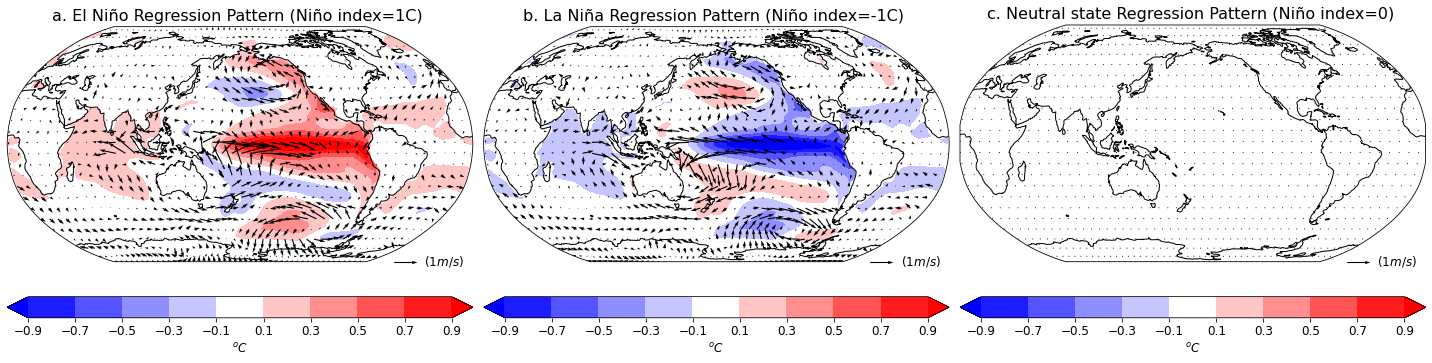

In [53]:
#### Anomalías características de un evento con índice Nino es igual a SSTA*Nino, UA*Nino, VA*Nino
#### Aquí graficaremos un patrón asociada a La Niña con Nino=-1, El Nino con Nino=1, y Neutral con Nino=0

######Start with Nino4,Nino3,Nino1+2

fontsize=12

#### To plot data
LON,LAT = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(1, 3, 1, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], reg_U[0::3,0::3],reg_V[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'a. El Niño Regression Pattern (Niño index=1C) ', fontsize=16)

####### La Niña

ax = fig.add_subplot(1, 3, 2, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, -reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], -reg_U[0::3,0::3],-reg_V[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'b. La Niña Regression Pattern (Niño index=-1C) ', fontsize=16)

####### Neutral state composite

ax = fig.add_subplot(1, 3, 3, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, reg_SST*0.00000000000001, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], 0.00000000000001*reg_U[0::3,0::3],0.00000000000001*reg_V[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'c. Neutral state Regression Pattern (Niño index=0) ', fontsize=16)

fig.tight_layout()

##### Plot them together (composite and regression)

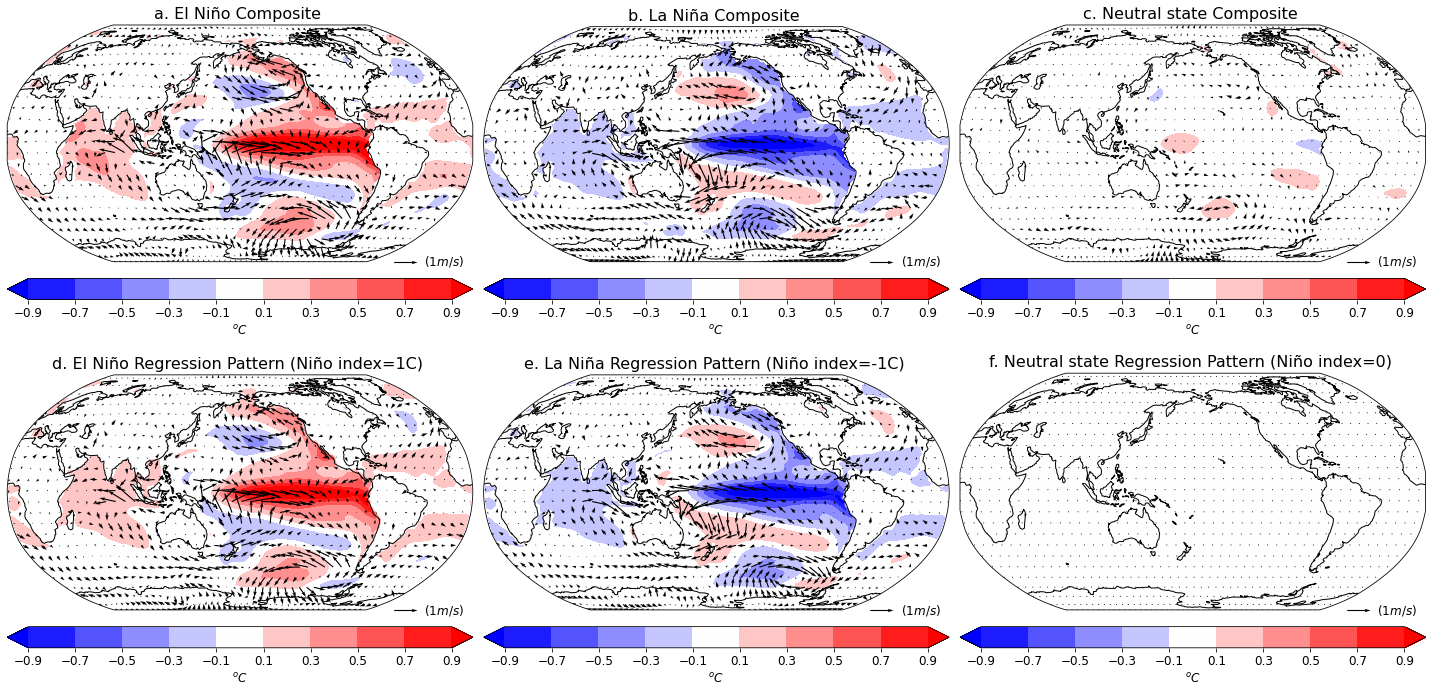

In [60]:
######Start with Nino4,Nino3,Nino1+2

fontsize=12

#### To plot data
LON,LAT = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(20, 10))

ax = fig.add_subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SSTA_nino_composite, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], UA_nino_composite[0::3,0::3],VA_nino_composite[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'a. El Niño Composite ', fontsize=16)

####### La Niña

ax = fig.add_subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SSTA_nina_composite, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], UA_nina_composite[0::3,0::3],VA_nina_composite[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'b. La Niña Composite ', fontsize=16)

####### Neutral state composite

ax = fig.add_subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SSTA_neutral_composite, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], UA_neutral_composite[0::3,0::3],VA_neutral_composite[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'c. Neutral state Composite ', fontsize=16)

#############################

ax = fig.add_subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], reg_U[0::3,0::3],reg_V[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'd. El Niño Regression Pattern (Niño index=1C) ', fontsize=16)

####### La Niña

ax = fig.add_subplot(2, 3, 5, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, -reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], -reg_U[0::3,0::3],-reg_V[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'e. La Niña Regression Pattern (Niño index=-1C) ', fontsize=16)

####### Neutral state composite

ax = fig.add_subplot(2, 3, 6, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, reg_SST*0.00000000000001, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], 0.00000000000001*reg_U[0::3,0::3],0.00000000000001*reg_V[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'f. Neutral state Regression Pattern (Niño index=0) ', fontsize=16)

fig.tight_layout()

### Ventajas y desventajas de composite y regression analysis

##### El composite analysis puede ser usado para diagnosticar la asimetría entre los patrones de El Niño y La Niña. El regression pattern no (positivos y negativos son simétricos)

In [63]:


SSTA_nino_asym=(1/2)*(SSTA_nino_composite+SSTA_nina_composite)
SSTA_nino_sym=(1/2)*(SSTA_nino_composite-SSTA_nina_composite)

UA_nino_asym=(1/2)*(UA_nino_composite+UA_nina_composite)
UA_nino_sym=(1/2)*(UA_nino_composite-UA_nina_composite)

VA_nino_asym=(1/2)*(VA_nino_composite+VA_nina_composite)
VA_nino_sym=(1/2)*(VA_nino_composite-VA_nina_composite)


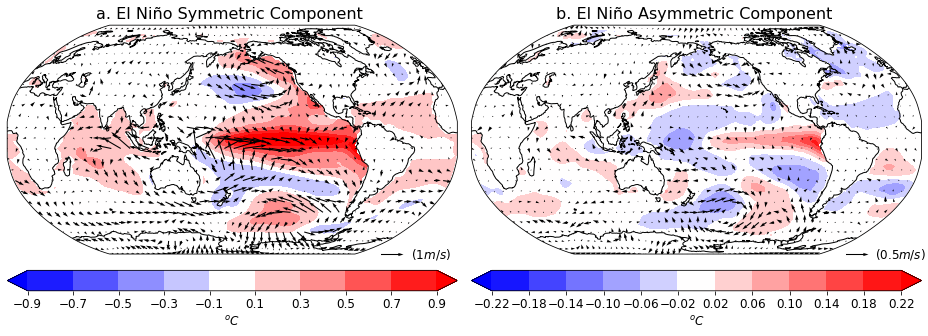

In [81]:
######Start with Nino4,Nino3,Nino1+2

fontsize=12

#### To plot data
LON,LAT = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(13, 5))

ax = fig.add_subplot(1, 2, 1, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.9,0.91,0.2)
h=plt.contourf(lon, lat, SST_nino_sym, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], U_nino_sym[0::3,0::3],V_nino_sym[0::3,0::3],transform=crs, scale=20)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'a. El Niño Symmetric Component ', fontsize=16)

########

ax = fig.add_subplot(1, 2, 2, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-0.22,0.221,0.04)
h=plt.contourf(lon, lat, SST_nino_asym, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05,ticks=[-0.22,-0.18,-0.14,-0.10,-0.06,-0.02,0.02,0.06,0.1,0.14,0.18,0.22])
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], U_nino_asym[0::3,0::3],V_nino_asym[0::3,0::3],transform=crs, scale=10)
ax.quiverkey(q, X=0.88, Y=0.0, U=0.5,label=r'$(0.5m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'b. El Niño Asymmetric Component ', fontsize=16)

fig.tight_layout()

##### Con regresión podemos tener el patrón para cualquier valor del índice. Eso no se puede hacer con el composite (si se puede variar el umbral del composite)



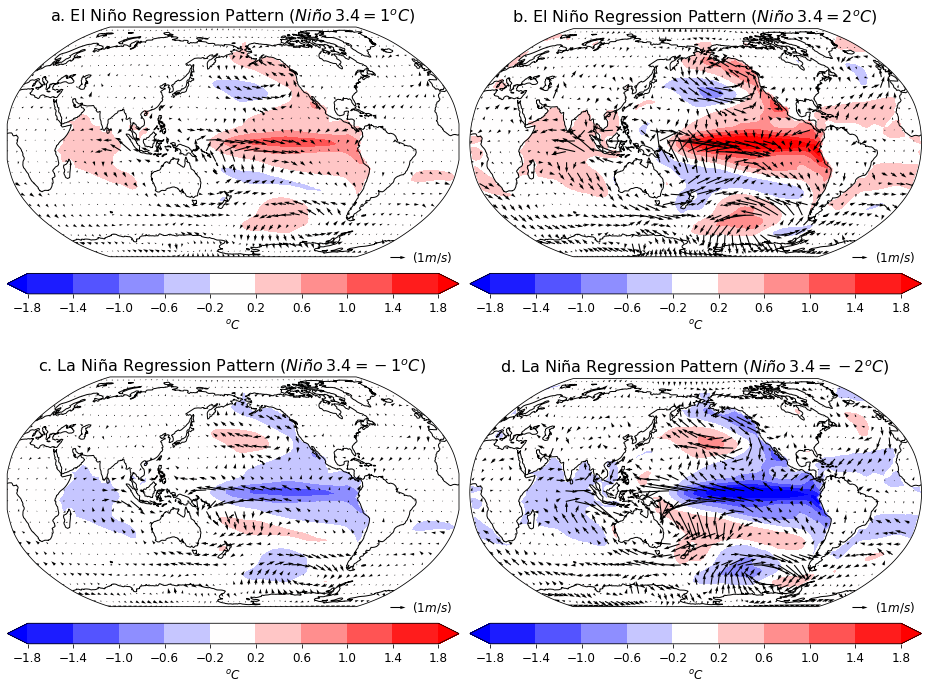

In [90]:
######Start with Nino4,Nino3,Nino1+2

fontsize=12

#### To plot data
LON,LAT = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(13, 10))

ax = fig.add_subplot(2, 2, 1, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-1.8,1.81,0.4)
h=plt.contourf(lon, lat, reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], reg_U[0::3,0::3],reg_V[0::3,0::3],transform=crs, scale=30)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'a. El Niño Regression Pattern ($Niño\:3.4=1^{o}C$) ', fontsize=16)

#########

ax = fig.add_subplot(2, 2, 2, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-1.8,1.81,0.4)
h=plt.contourf(lon, lat, 2*reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], 2*reg_U[0::3,0::3],2*reg_V[0::3,0::3],transform=crs, scale=30)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'b. El Niño Regression Pattern ($Niño\:3.4=2^{o}C$) ', fontsize=16)

#############################

ax = fig.add_subplot(2, 2, 3, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-1.8,1.81,0.4)
h=plt.contourf(lon, lat, -reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], -reg_U[0::3,0::3],-reg_V[0::3,0::3],transform=crs, scale=30)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'c. La Niña Regression Pattern ($Niño\:3.4=-1^{o}C$) ', fontsize=16)

#############################

ax = fig.add_subplot(2, 2, 4, projection=ccrs.Robinson(central_longitude=180.0))
crs=ccrs.PlateCarree()

# make the map global rather than have it zoom in to
# the extents of any plotted data
# ax.set_global()

#ax.stock_img()
ax.coastlines()

contour_levels = np.arange(-1.8,1.81,0.4)
h=plt.contourf(lon, lat, -2*reg_SST, transform=crs,cmap='bwr',levels=contour_levels, extend='both')

cbar = plt.colorbar(h, orientation='horizontal',pad=0.05)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$^{o}C$', fontsize=12)

##### Add wind data
###Thin this out a little bit
q=ax.quiver(LON[0::3,0::3], LAT[0::3,0::3], -2*reg_U[0::3,0::3],-2*reg_V[0::3,0::3],transform=crs, scale=30)
ax.quiverkey(q, X=0.88, Y=0.0, U=1,label=r'$(1m/s)$', labelpos='E',\
           color='k', fontproperties={'size': 'large'})

ax.set_title(r'd. La Niña Regression Pattern ($Niño\:3.4=-2^{o}C$) ', fontsize=16)

fig.tight_layout()

#### Actividades

##### 1. Elija una región océanica de su interés (un área de alrededor de 20 grados de longitud y 20 grados de latitud de dimensión)

##### 2. Calcule un índice de anomalías de temperatura superficial del mar en esa zona. (De forma similar a como se calculó el índice Niño 3.4)

##### 3. Calcule y grafique los patrones espaciales (usando composite y regression analysis) asociados a las fases cálidas, neutras y frías de su índice.

##### 4. Es el patrón calculado asimétrico respecto a sus frases cálidas y frías?